In [1]:
# Import libraries
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load
from sklearn import metrics
# from sklearn.preprocessing import StandardScaler


In [2]:
# Set seeds for reproducibility
# torch.manual_seed(0)
# np.random.seed(0)

In [3]:
# Select the device to use for processing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# Load the validation dataset
data = pd.read_csv("datasets/train_dataset.csv")
val_data = pd.read_csv("datasets/val_dataset.csv")


In [5]:
# Prepare input features and target variable
X_val = val_data.drop("Price", axis=1).values
y_val = val_data["Price"].values


In [6]:
# Standardizing data
scaler = load('scaler.joblib') # StandardScaler()
X_val = scaler.transform(X_val)

In [7]:
# Convert data to PyTorch tensors
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)

In [8]:
# Define the neural network model
class HousePriceModel(nn.Module):
    def __init__(self, input_size):
        super(HousePriceModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    

In [9]:
# Define input size
input_size = X_val.shape[1]


In [10]:
# Load the trained model
model = HousePriceModel(input_size).to(device)
model.load_state_dict(torch.load("models/house_price_model.pth"))


<All keys matched successfully>

In [11]:
# Make predictions
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_tensor)


In [12]:
# # Move tensors back to CPU
y_val_pred = y_val_pred.cpu()


In [13]:
# Convert predictions to numpy array
predictions = np.round(y_val_pred.numpy().flatten()).astype(int)


In [14]:
# Print actual vs predicted prices
results_df = pd.DataFrame({'Actual Price': y_val, 'Predicted Price': predictions})
print("Actual vs Predicted Prices:")
print(results_df)


Actual vs Predicted Prices:
      Actual Price  Predicted Price
0           635000           570053
1           895000          1034202
2           269800           350215
3           550000           411032
4           670000           667520
...            ...              ...
2919        620000           502954
2920        650000           426414
2921        599000           589359
2922        510000           707421
2923        354000           344547

[2924 rows x 2 columns]


In [15]:
# Check model performance
print(f'MAE: {metrics.mean_absolute_error(y_val, predictions):.4f}')
print(f'MSE: {metrics.mean_squared_error(y_val, predictions):.4f}')
print(f'RMSE: {metrics.mean_squared_error(y_val, predictions, squared=False):.4f}')
print(f'VarScore: {metrics.explained_variance_score(y_val, predictions):.4f}')


MAE: 113487.1840
MSE: 29674002173.9973
RMSE: 172261.4355
VarScore: 0.7346


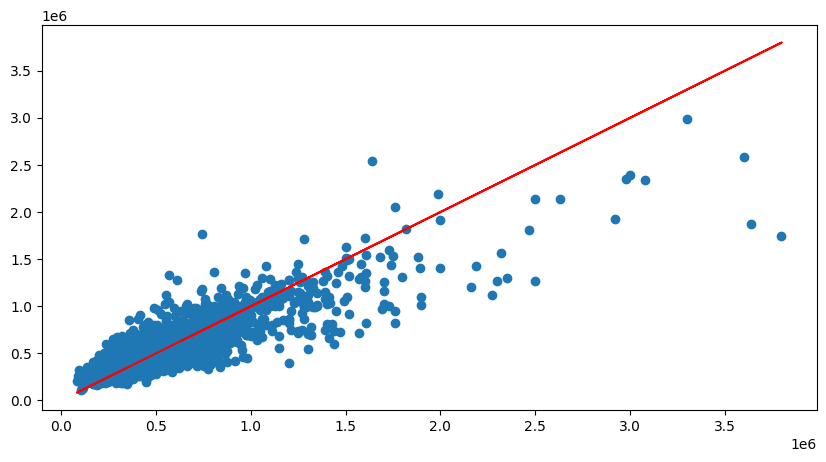

In [16]:
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_val, predictions)
plt.plot(y_val, y_val,'r')


In [17]:
# Check the device where the model parameters are located
device = next(model.parameters()).device

if device.type == 'cuda':
    print("Model is trained on GPU.")
else:
    print("Model is trained on CPU.")
    

Model is trained on GPU.
